In [59]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

plt.style.use("seaborn-v0_8")
sns.set_theme()


In [61]:
# Load data
df = pd.read_csv("delhiaqi.csv")  # same file you shared

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    561 non-null    object 
 1   co      561 non-null    float64
 2   no      561 non-null    float64
 3   no2     561 non-null    float64
 4   o3      561 non-null    float64
 5   so2     561 non-null    float64
 6   pm2_5   561 non-null    float64
 7   pm10    561 non-null    float64
 8   nh3     561 non-null    float64
dtypes: float64(8), object(1)
memory usage: 39.6+ KB


In [63]:
# Parse datetime and create time features
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["hour"] = df["date"].dt.hour
df["dayofweek"] = df["date"].dt.dayofweek  # 0=Mon


In [65]:
#Basic cleaning (handle missing values if any)
df.isna().sum()

# Example: forward-fill then back-fill for simplicity
df = df.ffill().bfill()


In [67]:
# Here we treat PM2.5 and PM10 as key AQI drivers (simple average - not official method)
df["AQI_proxy"] = df[["pm2_5", "pm10"]].mean(axis=1)
df[["date", "pm2_5", "pm10", "AQI_proxy"]].head()


,date,pm2_5,pm10,AQI_proxy
0,2023-01-01 00:00:00,169.29,194.64,181.965
1,2023-01-01 01:00:00,182.84,211.08,196.960
2,2023-01-01 02:00:00,220.25,260.68,240.465
3,2023-01-01 03:00:00,252.90,304.12,278.510
4,2023-01-01 04:00:00,266.36,322.80,294.580


In [95]:
# Most polluted hour (single worst timestamp)
worst_row = df.loc[df["AQI_proxy"].idxmax(), ["date", "AQI_proxy", "pm2_5", "pm10"]]

print("Most polluted hour in the dataset:")
print(f"Date & time : {worst_row['date']}")
print(f"AQI proxy   : {worst_row['AQI_proxy']:.2f}")
print(f"PM2.5       : {worst_row['pm2_5']:.2f}")
print(f"PM10        : {worst_row['pm10']:.2f}")


Most polluted hour in the dataset:
Date & time : 2023-01-19 17:00:00
AQI proxy   : 1404.74
PM2.5       : 1310.20
PM10        : 1499.27


In [97]:
# Most polluted days (by daily average AQI_proxy)
daily_mean = (
    df
    .groupby(df["date"].dt.date)["AQI_proxy"]
    .mean()
    .sort_values(ascending=False)
)

print("Top 5 most polluted days (by daily mean AQI proxy):")
for d, val in daily_mean.head(5).items():
    print(f"{d}  ->  {val:.2f}")


Top 5 most polluted days (by daily mean AQI proxy):
2023-01-02  ->  764.13
2023-01-13  ->  632.07
2023-01-09  ->  604.01
2023-01-19  ->  568.91
2023-01-01  ->  489.49


In [99]:
# Time of day usually most polluted (average over all days)
hour_mean = (
    df
    .groupby(df["date"].dt.hour)["AQI_proxy"]
    .mean()
    .sort_values(ascending=False)
)

print("Hours of day with highest average AQI proxy:")
for h, val in hour_mean.head(10).items():
    print(f"{h:02d}:00  ->  {val:.2f}")


Hours of day with highest average AQI proxy:
17:00  ->  599.74
15:00  ->  595.46
16:00  ->  588.04
18:00  ->  562.21
14:00  ->  559.85
13:00  ->  485.25
19:00  ->  457.70
12:00  ->  410.72
20:00  ->  410.11
03:00  ->  389.64


# Research Questions

1. **Key Pollutants**  
   - Which pollutants (PM2.5, PM10, NO2, SO2, O3, CO, NH3) show the highest levels and variability in Delhi?

2. **Temporal / Seasonal Patterns**  
   - How does AQI (proxy) and key pollutants change by **hour of day** and **day of month** (or later by season if data covers more months)?

3. **Pollutant Relationships**  
   - How strongly are PM2.5 and PM10 correlated with gaseous pollutants (NO2, SO2, CO, O3, NH3)?

4. **Geographical / Meteorological Context (qualitative)**  
   - How might Delhi’s landlocked geography, winter inversion, and regional sources (stubble burning, traffic, industry) help explain observed patterns?



In [93]:
# Summary stats for key pollutants
pollutants = ["pm2_5", "pm10", "no2", "so2", "co", "o3", "nh3"]
df[pollutants + ["AQI_proxy"]].describe().T


,count,mean,std,min,25%,50%,75%,max
pm2_5,561.0,358.256364,227.359117,60.10,204.450,301.17,416.65,1310.200
pm10,561.0,420.988414,271.287026,69.08,240.900,340.90,482.57,1499.270
no2,561.0,75.292496,42.473791,13.37,44.550,63.75,97.33,263.210
so2,561.0,64.655936,61.073080,5.25,28.130,47.21,77.25,511.170
co,561.0,3814.942210,3227.744681,654.22,1708.980,2590.18,4432.68,16876.220
o3,561.0,30.141943,39.979405,0.00,0.070,11.80,47.21,164.510
nh3,561.0,26.425062,36.563094,0.63,8.230,14.82,26.35,267.510
AQI_proxy,561.0,389.622389,248.957181,64.59,222.945,321.55,449.59,1404.735


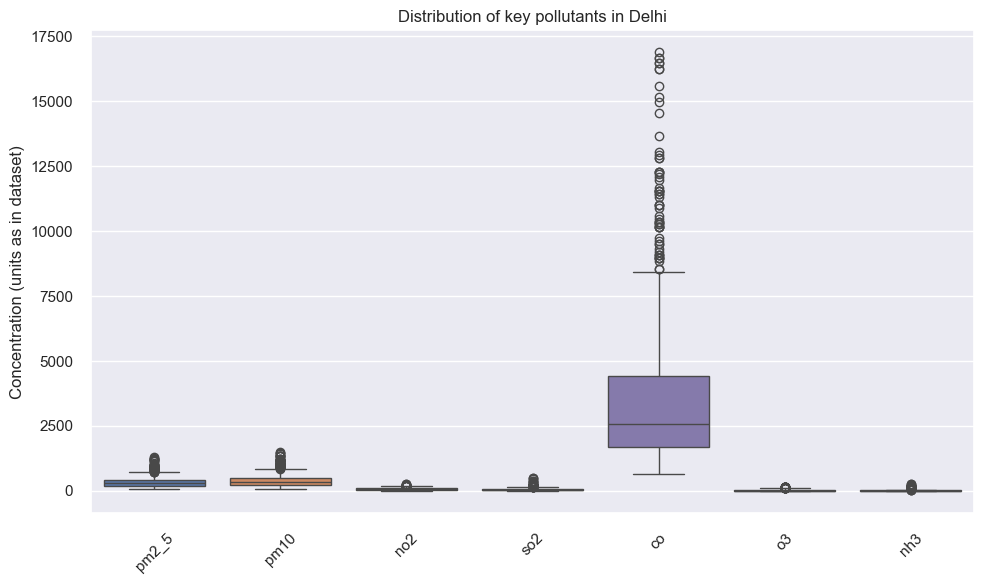

In [101]:
# Boxplot of pollutant distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[pollutants])
plt.title("Distribution of key pollutants in Delhi")
plt.ylabel("Concentration (units as in dataset)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

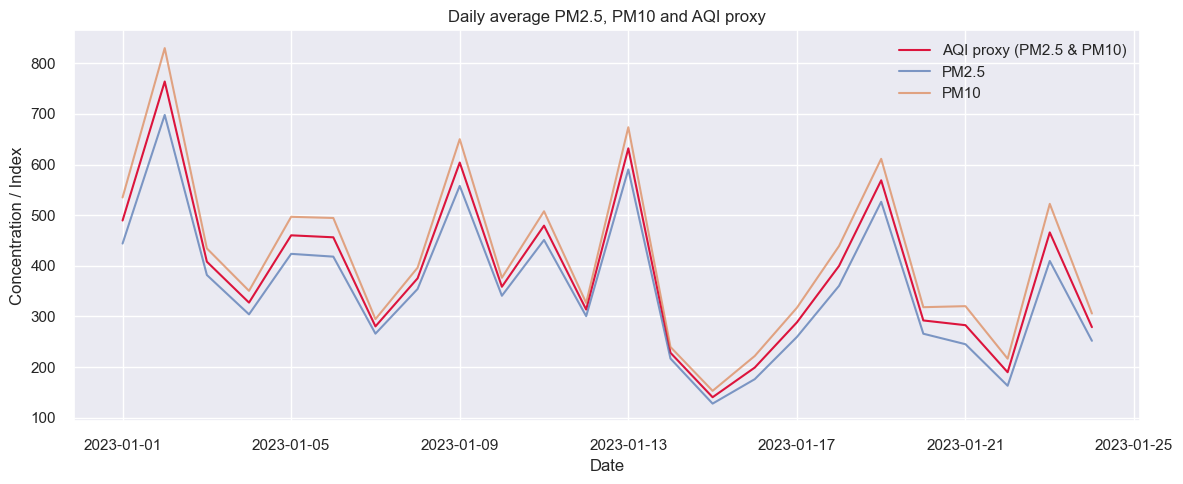

In [73]:
# Resample to daily mean to smooth hourly noise
daily = df.set_index("date").resample("D")[["pm2_5", "pm10", "AQI_proxy"]].mean()

plt.figure(figsize=(12, 5))
plt.plot(daily.index, daily["AQI_proxy"], label="AQI proxy (PM2.5 & PM10)", color="crimson")
plt.plot(daily.index, daily["pm2_5"], label="PM2.5", alpha=0.7)
plt.plot(daily.index, daily["pm10"], label="PM10", alpha=0.7)
plt.title("Daily average PM2.5, PM10 and AQI proxy")
plt.xlabel("Date")
plt.ylabel("Concentration / Index")
plt.legend()
plt.tight_layout()
plt.show()


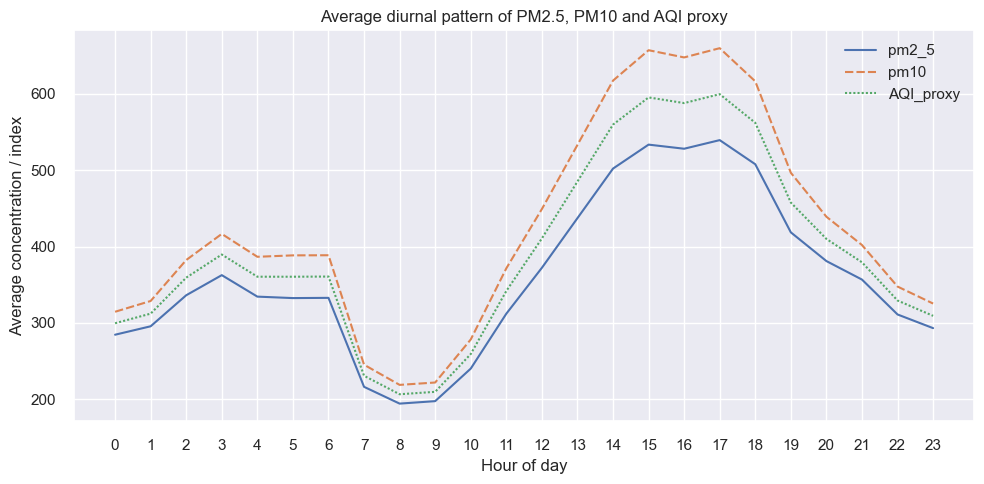

In [75]:
# Hourly pattern (average across all days)
hourly = df.groupby("hour")[["pm2_5", "pm10", "AQI_proxy"]].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly[["pm2_5", "pm10", "AQI_proxy"]])
plt.title("Average diurnal pattern of PM2.5, PM10 and AQI proxy")
plt.xlabel("Hour of day")
plt.ylabel("Average concentration / index")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


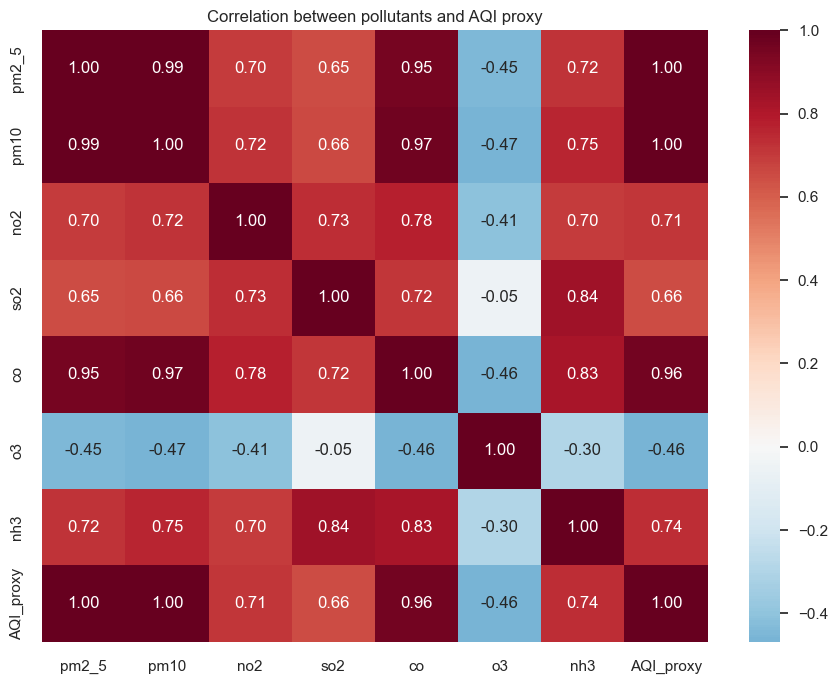

In [77]:
# Correlation matrix
corr = df[pollutants + ["AQI_proxy"]].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Correlation between pollutants and AQI proxy")
plt.tight_layout()
plt.show()


In [79]:
# Example: numerical correlation between PM2.5 and PM10
r, p = pearsonr(df["pm2_5"], df["pm10"])
print(f"Correlation PM2.5 vs PM10: r = {r:.2f}, p-value = {p:.3g}")


Correlation PM2.5 vs PM10: r = 0.99, p-value = 0


In [81]:
# Daily AQI proxy statistics
daily_stats = daily["AQI_proxy"].describe()
daily_stats


count     24.000000
mean     386.735159
std      153.458416
min      140.279583
25%      282.040990
50%      366.906458
75%      469.305313
max      764.126458
Name: AQI_proxy, dtype: float64

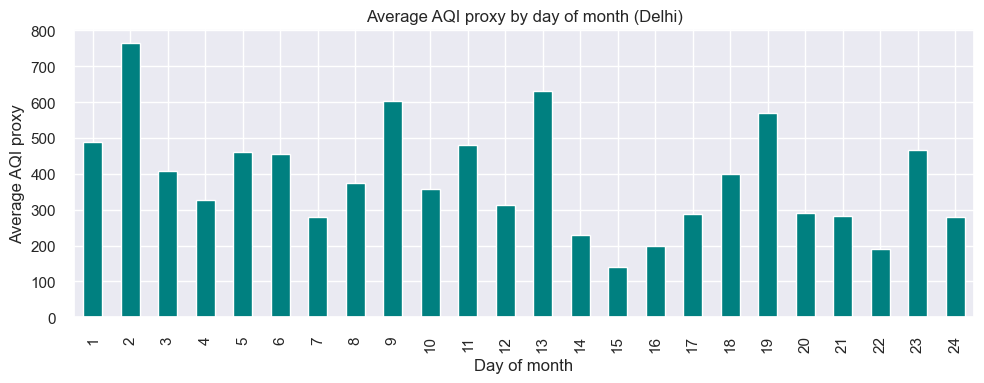

In [83]:
# Bar: mean AQI proxy by day of month
day_mean = df.groupby("day")["AQI_proxy"].mean()

plt.figure(figsize=(10, 4))
day_mean.plot(kind="bar", color="teal")
plt.title("Average AQI proxy by day of month (Delhi)")
plt.xlabel("Day of month")
plt.ylabel("Average AQI proxy")
plt.tight_layout()
plt.show()


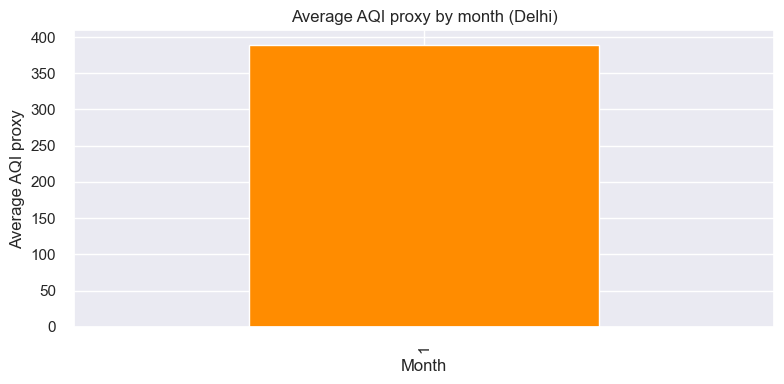

In [85]:
# Example if multiple months exist
month_mean = df.groupby("month")["AQI_proxy"].mean()
plt.figure(figsize=(8, 4))
month_mean.plot(kind="bar", color="darkorange")
plt.title("Average AQI proxy by month (Delhi)")
plt.xlabel("Month")
plt.ylabel("Average AQI proxy")
plt.tight_layout()
plt.show()


In [105]:
# Define rough AQI bands for proxy 
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

df["AQI_band"] = df["AQI_proxy"].apply(aqi_category)

df["AQI_band"].value_counts(normalize=True) * 100


AQI_band
Severe          31.907308
Very Poor       24.420677
Poor            24.242424
Moderate        18.360071
Satisfactory     1.069519
Name: proportion, dtype: float64

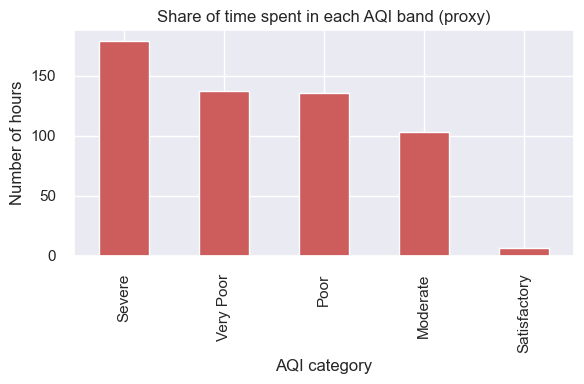

In [89]:
plt.figure(figsize=(6, 4))
df["AQI_band"].value_counts().plot(kind="bar", color="indianred")
plt.title("Share of time spent in each AQI band (proxy)")
plt.xlabel("AQI category")
plt.ylabel("Number of hours")
plt.tight_layout()
plt.show()


### Interpretation: Key environmental challenges in Delhi

- **Particulate pollution dominates**: PM2.5 and PM10 show the highest average levels and strong correlation with the AQI proxy, confirming that fine and coarse particles are the primary drivers of poor air quality.
- **Diurnal pattern**: Morning and late-night hours tend to have higher particle concentrations, likely due to traffic emissions, domestic combustion, and a shallow boundary layer that traps pollutants near the surface.
- **Limited dispersion**: Delhi’s landlocked location, winter inversion, and low wind conditions reduce dispersion, allowing pollutants from local sources (traffic, industry, construction) and regional sources (stubble burning) to accumulate.
- **Health relevance**: Long durations in “Poor” to “Severe” bands imply increased risk of respiratory and cardiovascular issues, highlighting the need for targeted emission control and public-health advisories.
